## Trend Segmentation using Velocity, Acceleration, and Smoothing
We will cover:
1. Discussion of trend segments
2. Examine algorithm for segmenting data set using velocity and Acceleration
3. Performing linear regression on trend segments

# ETL The Data

In [1]:
# Import libraries to manipulate data
import numpy 

In [2]:
import pandas

In [3]:
import matplotlib.pyplot as pyplot

In [4]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

In [5]:
# Read the file into a dataframe
file_path = "../../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
pandas_dataframe = pandas_dataframe.sort_values("date")

# Filter out data for a specific ticker
aaba_dataframe = pandas_dataframe.loc[pandas_dataframe.ticker == "AABA"]

# Filter down to the last month of data
# aaba_dataframe = aaba_dataframe.loc[aaba_dataframe["date"] > '2019-07-01']

# Remove unwanted columns
aaba_dataframe = aaba_dataframe[["date","open"]]

# Reset the index
aaba_dataframe.index = range(0, aaba_dataframe.shape[0])

# Show the first few rows
aaba_dataframe = aaba_dataframe

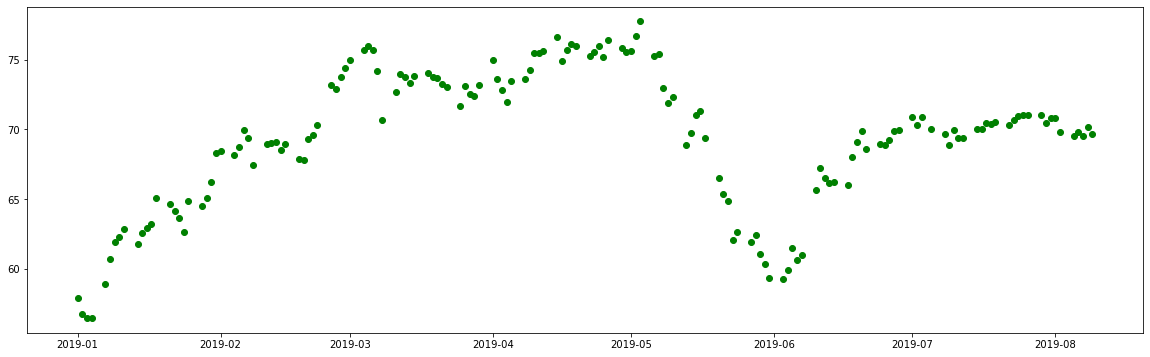

In [6]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(aaba_dataframe["date"], aaba_dataframe["open"], color="green")

# Smooth the data

In [7]:
def calculate_moving_average(column, window):
    n = len(column)
    smoothed_values = numpy.zeros(n)

    ma_terms = []
    for t in range(0, n):
        x = column[t]
        ma_terms.append(x)
        if len(ma_terms) > window:
            ma_terms.pop(0) 
        ma = numpy.array(ma_terms).mean()
        smoothed_values[t] = ma
        
    return smoothed_values
        
def calculate_exponential_moving_average(column, window, decay):
    n = len(column)
    smoothed_values = numpy.zeros(n)

    ma_terms = []
    for t in range(0, n):
        x = column[t]
        ma_terms.append(x)
        if len(ma_terms) > window:
            ma_terms.pop(0) 
        ma = list(pandas.Series(ma_terms).ewm(com=decay).mean())[-1]
        smoothed_values[t] = ma
        
    return smoothed_values

We can calculate a smooth line and iteratively smooth the line by repeatedly applying the smoothing technique.

In [8]:
aaba_dataframe["open_smooth"] = calculate_exponential_moving_average(aaba_dataframe["open"], 5, 0.9)
aaba_dataframe["open_smooth2"] = calculate_exponential_moving_average(aaba_dataframe["open_smooth"], 5, 0.6)
aaba_dataframe["open_smooth3"] = calculate_exponential_moving_average(aaba_dataframe["open_smooth2"], 5, 0.2)

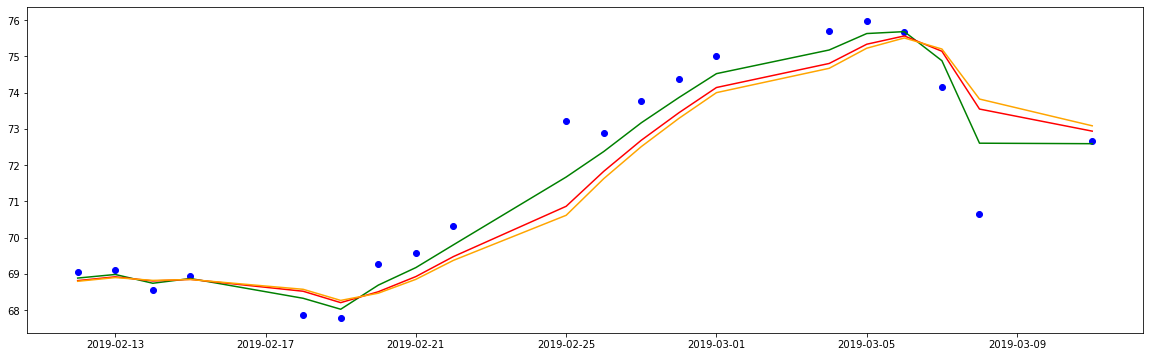

In [9]:
start = 30
end = aaba_dataframe["open"].shape[0]
end = 50

date = aaba_dataframe["date"][start:end]
opens = aaba_dataframe["open"][start:end]
smooth = aaba_dataframe["open_smooth"][start:end]
smooth2 = aaba_dataframe["open_smooth2"][start:end]
smooth3 = aaba_dataframe["open_smooth3"][start:end]

figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(date, opens, color="blue")
axis.plot(date, smooth, color="green")
axis.plot(date, smooth2, color="red")
axis.plot(date, smooth3, color="orange")

Notice that some less important inflection points are removed. The local min/max inflection points are preserved but shifted to the right one tick.

# Calculate the acceleration and velocity of the smooth line

In [10]:
aaba_dataframe["open_smooth_v"] = aaba_dataframe["open_smooth3"].diff()
aaba_dataframe["open_smooth_a"] = aaba_dataframe["open_smooth_v"].diff()
aaba_dataframe[["date","open","open_smooth3", "open_smooth_v", "open_smooth_a"]].head()

,date,open,open_smooth3,open_smooth_v,open_smooth_a
0,2019-01-01,57.94,57.940000,NaN,NaN
1,2019-01-02,56.78,57.449314,-0.490686,NaN
2,2019-01-03,56.48,57.043379,-0.405934,0.084752
3,2019-01-04,56.50,56.791409,-0.251970,0.153964
4,2019-01-07,58.90,57.329752,0.538343,0.790313


Text(0.5, 1.0, 'Acceleration')

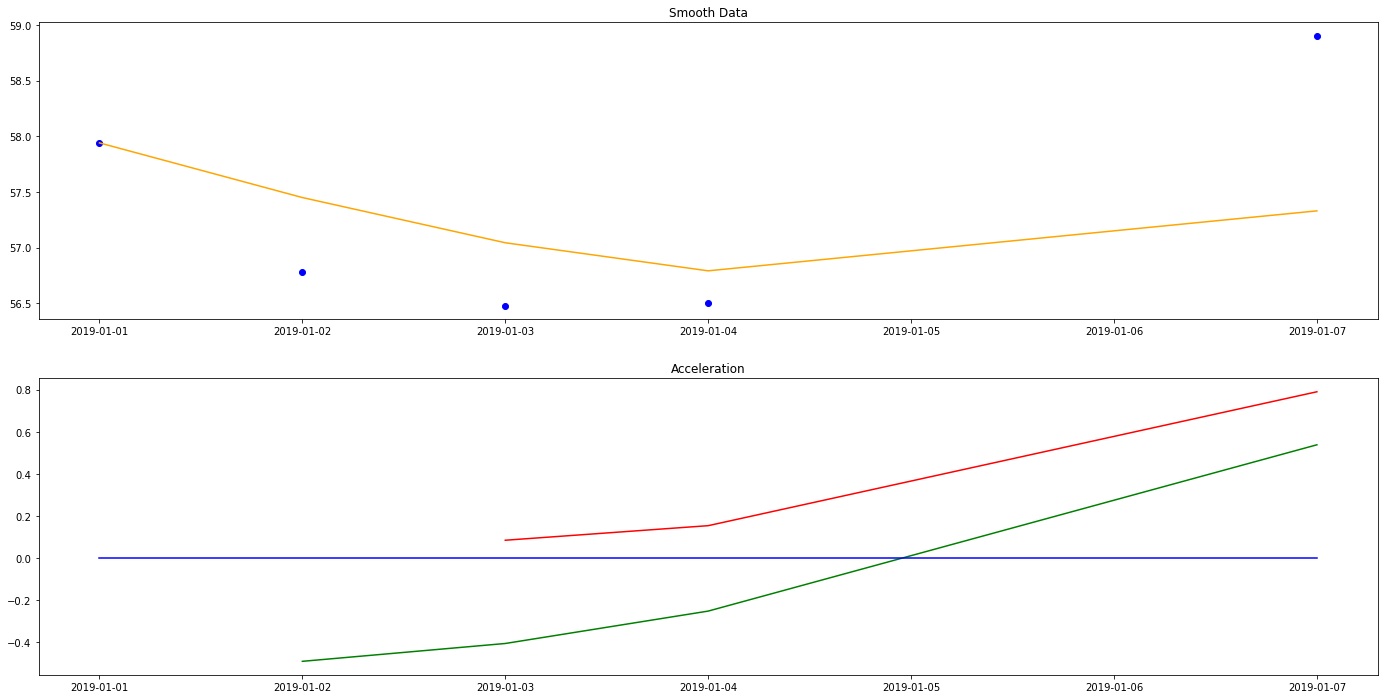

In [11]:
start = 0
end = 5

figure, axis = pyplot.subplots(nrows=2,ncols=1,figsize=(24,12))

axis[0].scatter(aaba_dataframe["date"][start:end], aaba_dataframe["open"][start:end], color="blue")
axis[0].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth3"][start:end], color="orange")
axis[0].set_title("Smooth Data")

axis[1].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_v"][start:end], color="green")
axis[1].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_a"][start:end], color="red")
axis[1].plot(aaba_dataframe["date"][start:end], numpy.zeros(end - start), color="blue")
axis[1].set_title("Acceleration")

# Partition the data into segments

Lets look for inflection points marked by changes in direction of the slope of the smooth line.

In [34]:
def calculate_inflection_point(column):
    
    n = len(column)
    ips = pandas.Series(numpy.nan)
    for t in range(2, n):
        
        s1 = column[t - 1] - column[t - 2]
        s2 = column[t] - column[t - 1]
        
        if not utilities.same_signs(s1, s2):
            ips[t] = 1
    return ips          
        

In [35]:
aaba_dataframe["open_smooth_ip"] = calculate_inflection_point(aaba_dataframe["open_smooth"]) * aaba_dataframe["open"]
aaba_dataframe[["date","open","open_smooth_v", "open_smooth_ip"]].head()

,date,open,open_smooth_v,open_smooth_ip
0,2019-01-01,57.94,NaN,NaN
1,2019-01-02,56.78,-0.787143,NaN
2,2019-01-03,56.48,-0.396250,NaN
3,2019-01-04,56.50,-0.142216,NaN
4,2019-01-07,58.90,1.232341,58.9


Text(0.5, 1.0, 'Velocity')

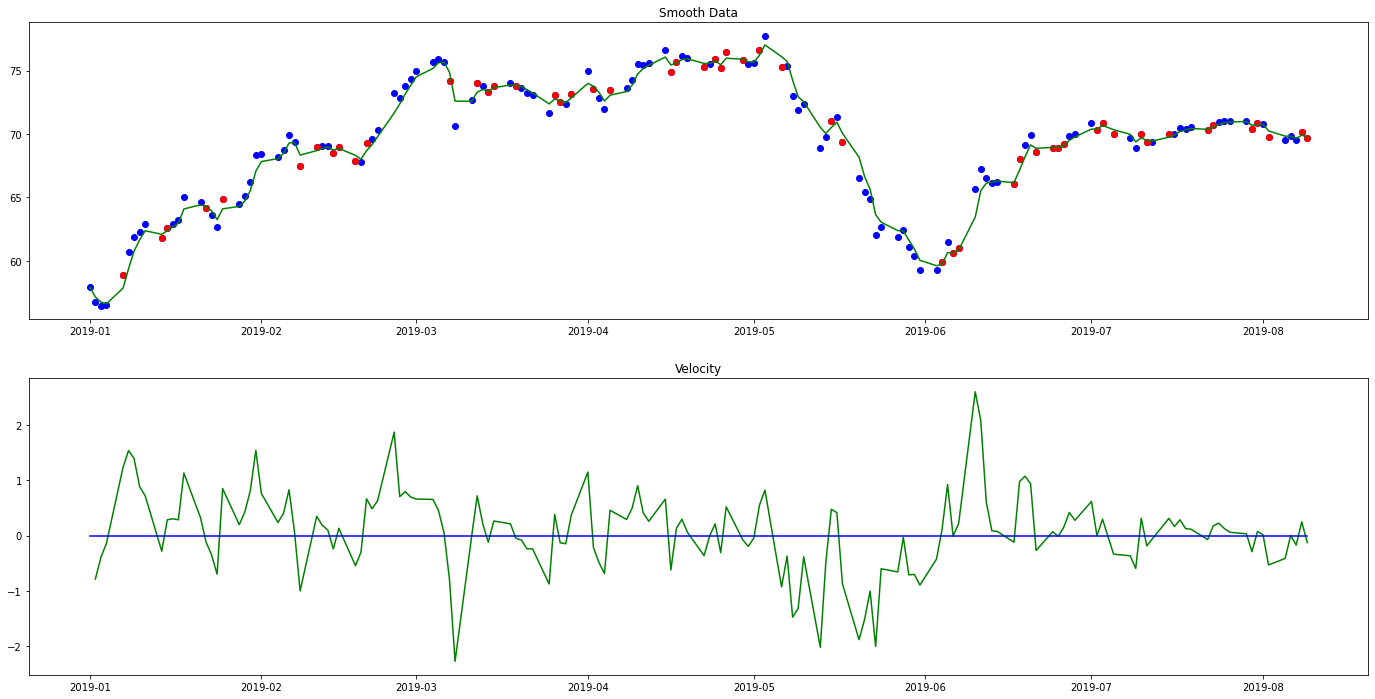

In [37]:
start = 0
end = aaba_dataframe["open"].shape[0]

figure, axis = pyplot.subplots(nrows=2,ncols=1,figsize=(24,12))

axis[0].scatter(aaba_dataframe["date"][start:end], aaba_dataframe["open"][start:end], color="blue")
axis[0].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth"][start:end], color="green")
#axis[0].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth2"][start:end], color="red")
#axis[0].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth3"][start:end], color="orange")
axis[0].scatter(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_ip"][start:end], color="red")
axis[0].set_title("Smooth Data")

axis[1].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_v"][start:end], color="green")
#axis[1].plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_a"][start:end], color="red")
axis[1].plot(aaba_dataframe["date"][start:end], numpy.zeros(end - start), color="blue")
axis[1].set_title("Velocity")

# Execute trading strategy

Using the segmentation I will impliment a trading strategy using a simple linear regression. The basic idea is that the model will be trained only on data that is part of the same segment. The trained model will be used to make predictions about tomorrows price. If we think the price will go up, we will buy. If we think the price will go down, we will sell.

In [21]:
# Load library for linear regression
from sklearn.linear_model import LinearRegression

In [19]:
# Create a column with the ordinals
aaba_dataframe["ordinals"] = aaba_dataframe["date"].apply(lambda x: x.toordinal())

In [20]:
# Add some empty columns for the trading
aaba_dataframe["diff"] = numpy.nan
aaba_dataframe["info"] = ""
aaba_dataframe["train"] = ""
aaba_dataframe["open_pred"] = numpy.nan
aaba_dataframe["signals"] = ""
aaba_dataframe["pred"] = numpy.nan
aaba_dataframe["buy"] = numpy.nan
aaba_dataframe["sell"] = numpy.nan

In [38]:
# Loop through the data points and generate trading signals
def generate_trading_signals(data, ips):
    
    n = len(data)
    
    signals = pandas.Series(numpy.empty(n))
    
    for t in range(1, n):

        signal = "hold"
        
        # If we are at an inflection point, we do not have enough information
        ip = ips[t]
        if ip > 0:
            df.at[t, "info"] = False
            df.at[t + 1, "open_pred"] = aaba_dataframe["open"][t] # If we cannot make a pred, put mv
            continue
        
        # Find the index of the previous inflection point (if we have one)
        # That index will mark the start of the segment
        segment_start_index = 0
        for x in range(0, t):
            ip = df["{0}_smooth_ip".format(column_name)][t - x]
            if bool(ip > 0):
                segment_start_index = t - x
                break

        # Determine if we have enough info (previous ip is at least 1 point away)
        diff = t - segment_start_index        
        enough_info = diff >= 1
        df.at[t, "diff"] = diff
        df.at[t, "info"] = enough_info
        df.at[t + 1, "open_pred"] = aaba_dataframe["open"][t] # If we cannot make a pred, put mv
        if not enough_info:
            continue
        
        # Fit a linear regression to the data
        train_x = df["ordinals"][segment_start_index:t+1].values.reshape(-1, 1)
        train_y = df["open"][segment_start_index:t+1]
        
        reg = LinearRegression().fit(train_x, train_y)      
        
        # Make a prediction for the next date
        x = df["ordinals"][t + 1]
        x = x.reshape(-1, 1) # I am not sure why we need to reshape the data
        pred = reg.predict(x)
        df.at[t + 1, "open_pred"] = pred[0]
        
        df.at[t, "train"] = str(list(train_y))
        
        # Determine the slope of the line
        slope = reg.coef_[0]
        df.at[t, "slope"] = slope
              
        # Determine if we should buy or sell
        # 
        
        o = df["open"][t]
        signal = "hold"
        if pred > o or slope > 0:
            signal = "buy"
            df.at[t, "buy"] = o
        elif pred < o or slope < 0:
            signal = "sell"
            df.at[t, "sell"] = o
        
generate_trading_signals(aaba_dataframe, "open")

TypeError: '>' not supported between instances of 'str' and 'int'

In [23]:
# Configure pandas to show all the rows
pandas.set_option('display.max_columns', None)  # or 1000
pandas.set_option('display.max_rows', None)  # or 1000
pandas.set_option('display.max_colwidth', None)  # or 199
aaba_dataframe.head()

,date,open,open_smooth,open_smooth2,open_smooth3,open_smooth_v,open_smooth_a,open_smooth_ip,open_smooth_ip2,ordinals,diff,info,train,open_pred,signals,pred,buy,sell,slope
0,2019-01-01,57.94,57.940000,57.940000,57.940000,NaN,NaN,NaN,NaN,737060.0,NaN,,,NaN,,NaN,NaN,NaN,NaN
1,2019-01-02,56.78,57.152857,57.367532,57.449314,-0.787143,NaN,NaN,NaN,737061.0,1.0,True,"[57.94, 56.78]",NaN,,NaN,NaN,56.78,-1.160
2,2019-01-03,56.48,56.756607,56.964448,57.043379,-0.396250,0.390893,NaN,NaN,737062.0,2.0,True,"[57.94, 56.78, 56.48]",55.620000,,NaN,NaN,56.48,-0.730
3,2019-01-04,56.50,56.614391,56.741248,56.791409,-0.142216,0.254034,NaN,NaN,737063.0,3.0,True,"[57.94, 56.78, 56.48, 56.5]",55.606667,,NaN,NaN,56.50,-0.462
4,2019-01-07,58.90,57.846731,57.437337,57.329752,1.232341,1.374557,58.9,58.9,737066.0,NaN,False,,54.846000,,NaN,NaN,NaN,NaN


In [24]:
cols = ["ordinals", "date", "open", "open_smooth_ip", "info", "train", "slope", "open_pred", "buy", "sell"]
aaba_dataframe[cols][0:20]

,ordinals,date,open,open_smooth_ip,info,train,slope,open_pred,buy,sell
0,737060.0,2019-01-01,57.94,NaN,,,NaN,NaN,NaN,NaN
1,737061.0,2019-01-02,56.78,NaN,True,"[57.94, 56.78]",-1.160000,NaN,NaN,56.78
2,737062.0,2019-01-03,56.48,NaN,True,"[57.94, 56.78, 56.48]",-0.730000,55.620000,NaN,56.48
3,737063.0,2019-01-04,56.50,NaN,True,"[57.94, 56.78, 56.48, 56.5]",-0.462000,55.606667,NaN,56.50
4,737066.0,2019-01-07,58.90,58.90,False,,NaN,54.846000,NaN,NaN
5,737067.0,2019-01-08,60.70,NaN,True,"[58.9, 60.7]",1.800000,58.900000,60.70,NaN
6,737068.0,2019-01-09,61.90,NaN,True,"[58.9, 60.7, 61.9]",1.500000,62.500000,61.90,NaN
7,737069.0,2019-01-10,62.31,NaN,True,"[58.9, 60.7, 61.9, 62.31]",1.143000,63.500000,62.31,NaN
8,737070.0,2019-01-11,62.87,NaN,True,"[58.9, 60.7, 61.9, 62.31, 62.87]",0.955000,63.810000,62.87,NaN
9,737073.0,2019-01-14,61.77,61.77,False,,NaN,66.111000,NaN,NaN


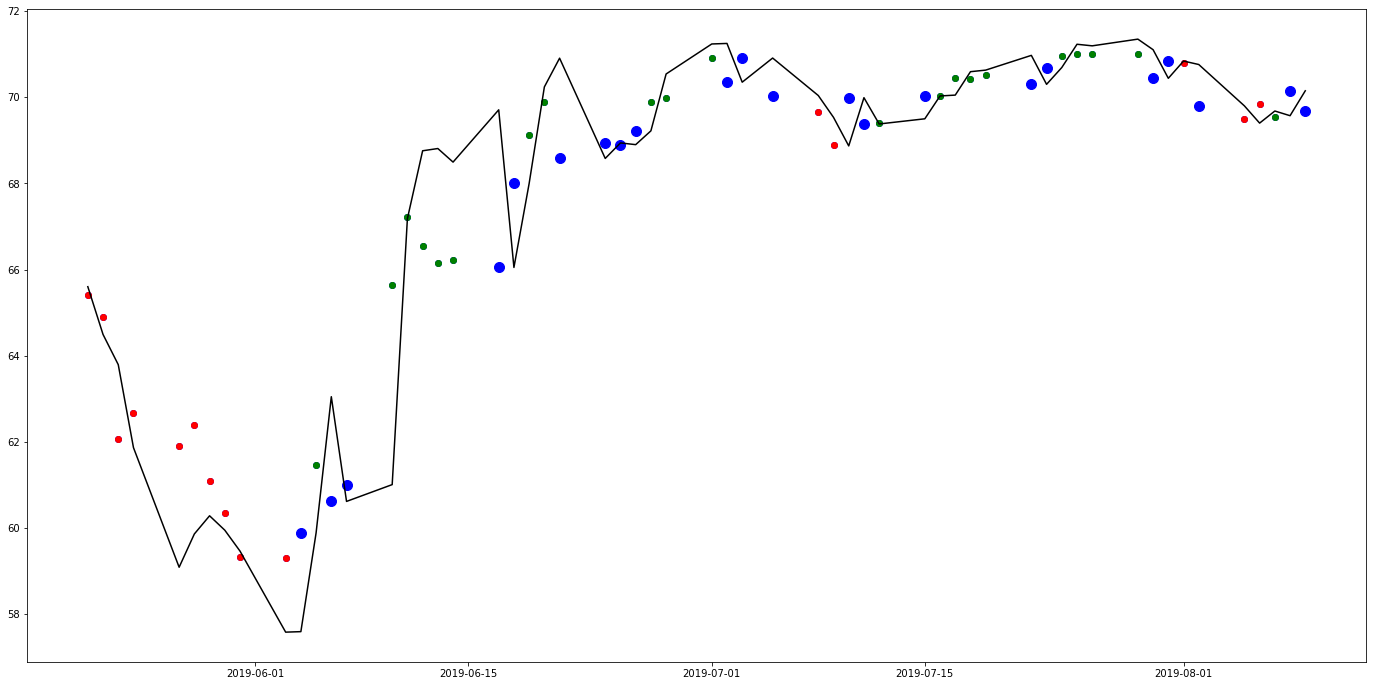

In [25]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(24,12))
start = 100
end = 200
axis.scatter(aaba_dataframe["date"][start:end], aaba_dataframe["open"][start:end], color="blue")
axis.scatter(aaba_dataframe["date"][start:end], aaba_dataframe["open_smooth_ip"][start:end], color="blue", s=100)

axis.plot(aaba_dataframe["date"][start:end], aaba_dataframe["open_pred"][start:end], color="black")
axis.scatter(aaba_dataframe["date"][start:end], aaba_dataframe["buy"][start:end], color="green")
axis.scatter(aaba_dataframe["date"][start:end], aaba_dataframe["sell"][start:end], color="red")

ValueError: x and y must have same first dimension, but have shapes (20,) and (158,)

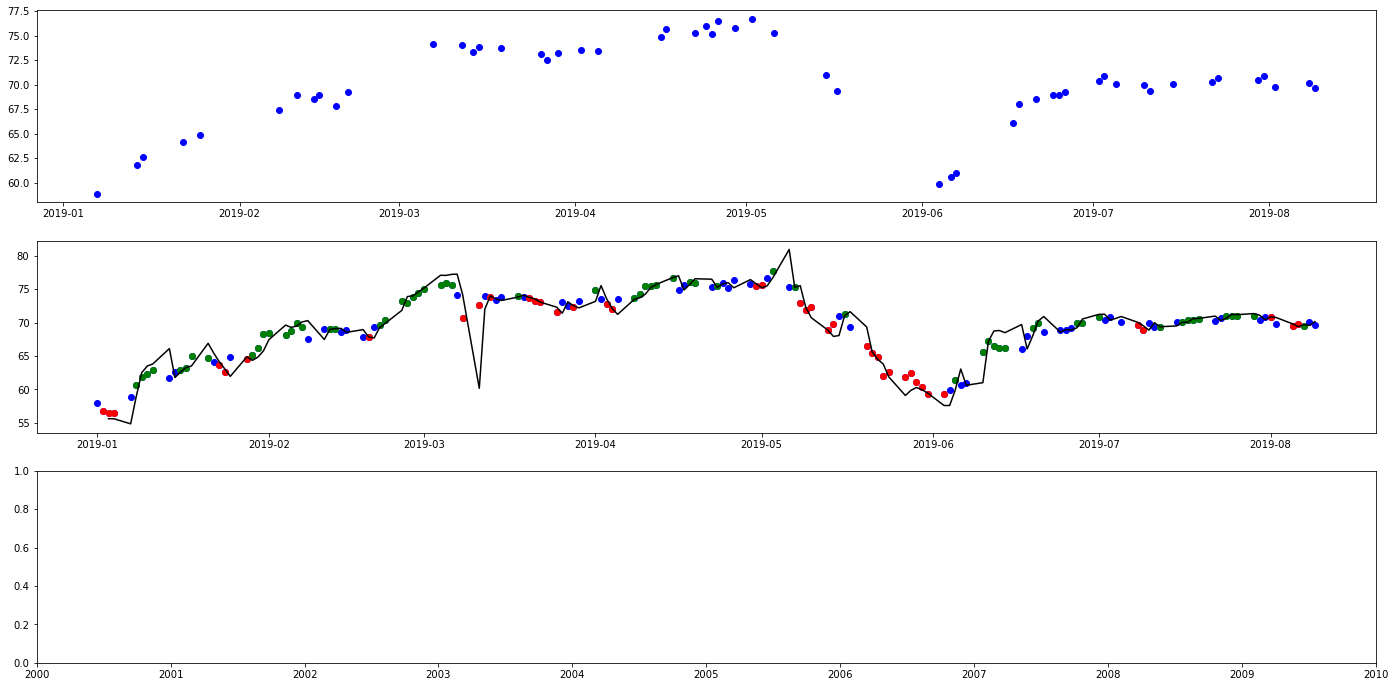

In [26]:
figure, axis = pyplot.subplots(nrows=3,ncols=1,figsize=(24,12))
n = aaba_dataframe["open"].shape[0]

axis[0].scatter(aaba_dataframe["date"], aaba_dataframe["open_smooth_ip"], color="blue")

axis[1].scatter(aaba_dataframe["date"], aaba_dataframe["open"], color="blue")
axis[1].plot(aaba_dataframe["date"], aaba_dataframe["open_pred"], color="black")
axis[1].scatter(aaba_dataframe["date"], aaba_dataframe["buy"], color="green")
axis[1].scatter(aaba_dataframe["date"], aaba_dataframe["sell"], color="red")

axis[2].plot(date, numpy.zeros(n-1), color="blue")
axis[2].scatter(aaba_dataframe["date"], aaba_dataframe["slope"], color="blue")

In [ ]:
date = aaba_dataframe["date"][1:]
o = aaba_dataframe["open"][1:]
o_hat = aaba_dataframe["open_pred"][1:]
buy = aaba_dataframe["buy"][1:]
sell = aaba_dataframe["sell"][1:]

figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(24,12))

axis.scatter(date, o, color="blue")
axis.plot(date, o_hat, color="green")
axis.scatter(date, buy, color="green", marker="s")
axis.scatter(date, sell, color="red", marker="s")

In [ ]:
aaba_dataframe["shares"] = numpy.zeros(n)
aaba_dataframe["cash"] = numpy.zeros(n)
aaba_dataframe["invested"] = numpy.zeros(n)
aaba_dataframe["sale"] = numpy.zeros(n)
aaba_dataframe["returns"] = numpy.zeros(n)
aaba_dataframe["ledger"] = ""


In [ ]:
# Set the starting condition
aaba_dataframe.at[0, "cash"] = 500

# Loop through the data points and make predictions using linear regression

ledger = {}

for t in range(1, n):
    
    # Find the index of the previous inflection point
    previous_ip = t
    for x in reversed(range(0, t)):
        ip = aaba_dataframe["open_ip"][x]
        
        previous_ip = x
        if bool(ip):
            break
   
    # Determine if we have enough info (previous ip is at least 1 point away)
    diff = t - previous_ip    
    enough_info = diff >= 2 and not bool(aaba_dataframe["open_ip"][t])
    aaba_dataframe.at[t, "info"]= enough_info
    
    # Update our ledger info as if no action took place
    old_cash = aaba_dataframe["cash"][t - 1]
    old_shares = aaba_dataframe["shares"][t - 1]
    old_invested = 0
    for price in ledger.keys():
        shares = ledger[price]
        invested = price * shares
        old_invested += invested

    aaba_dataframe.at[t, "cash"] = old_cash
    aaba_dataframe.at[t, "shares"] = old_shares
    aaba_dataframe.at[t, "returns"] = 0
    aaba_dataframe.at[t, "ledger"] = str(ledger)
    aaba_dataframe.at[t, "invested"] = old_invested
    
    # If we dont have enough info, do not do anything
    if not enough_info: 
        continue

    # Detemine trading activity
    # if the estimate is lower than market, sell because the market is overpaying
    # if the estimate is higher than market, buy because the market is undervaluing 
    o = aaba_dataframe["open"][t]
    signal = "none"
    if o_hat < o:
        signal = "sell"
    elif o_hat > o:
        signal = "buy"

    # Execute the trading activity
    if signal == "buy":

        shares_to_buy = int(old_cash / o)
        cost_to_buy = shares_to_buy * o

        # If you cannot buy anything, quit
        if shares_to_buy <= 0:
            continue

        # If you can buy somehting determine the cost
        new_cash = old_cash - cost_to_buy
        
        # Update ledger
        if o not in ledger.keys():
            ledger[o] = shares_to_buy
        else:
            ledger[o] += shares_to_buy
            
        # Determine how much is invested
        total_invested = 0
        for price in ledger.keys():
            shares = ledger[price]
            invested = price * shares
            total_invested += invested

        # update dataframe
        aaba_dataframe.at[t, "cash"] = new_cash
        aaba_dataframe.at[t, "shares"] = old_shares + shares_to_buy
        aaba_dataframe.at[t, "returns"] = 0
        aaba_dataframe.at[t, "ledger"] = str(ledger)
        aaba_dataframe.at[t, "invested"] = total_invested
        aaba_dataframe.at[t, "buy"] = o

    else:
        
        # If we cannot sell, quit
        if old_shares <= 0:
            continue
        
        # If we can sell, determine how much we can make
        # We only want to dump the shares we bought for less than current market price
        buy_prices_to_dump = []
        for buy_price in ledger.keys():
            if buy_price < o:
                buy_prices_to_dump.append(buy_price)
        if(len(buy_prices_to_dump) == 0):
            continue
        
        # Determine number of shares being sold
        shares_to_dump = 0
        for buy_price in buy_prices_to_dump:
            shares = ledger[buy_price]
            shares_to_dump += shares
            
        # Determine the investment of the sale
        investment_of_sale = 0
        for buy_price in buy_prices_to_dump:
            shares = ledger[buy_price]
            investment = shares * buy_price 
            investment_of_sale += investment
               
        # Update ledger
        for buy_price in buy_prices_to_dump:
            del ledger[buy_price]
        
        # Determine how much is invested
        total_invested = 0
        for price in ledger.keys():
            shares = ledger[price]
            invested = price * shares
            total_invested += invested
        
        # Update datafream
        new_shares = old_shares - shares_to_dump
        cash_from_sell = shares_to_dump * o
        
        aaba_dataframe.at[t, "cash"] = old_cash + cash_from_sell
        aaba_dataframe.at[t, "shares"] = new_shares
        aaba_dataframe.at[t, "returns"] = cash_from_sell - investment_of_sale
        aaba_dataframe.at[t, "ledger"] = str(ledger)
        
        aaba_dataframe.at[t, "sale"] = cash_from_sell
        aaba_dataframe.at[t, "invested"] = total_invested
        
        aaba_dataframe.at[t, "sell"] = o
    
    # Update our signal so we know we took an action
    aaba_dataframe.at[t, "signals"] = signal